In [1]:
import sys
sys.path.append("../") 

In [2]:
from __future__ import division

import argparse, time, logging, random, math

import numpy as np
import mxnet as mx

from mxnet import gluon, nd
from mxnet import autograd as ag
from mxnet.gluon import nn
from mxnet.gluon.data.vision import transforms

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(0.,1.)
])

In [4]:
num_gpus = 1
model_ctx = mx.cpu()

num_workers = 0
batch_size = 64 
train_data = gluon.data.DataLoader(
    gluon.data.vision.MNIST(train=True).transform_first(transform),
    batch_size=batch_size, shuffle=True, last_batch='discard', num_workers=num_workers)

val_data = gluon.data.DataLoader(
    gluon.data.vision.MNIST(train=False).transform_first(transform),
    batch_size=batch_size, shuffle=False, num_workers=num_workers)

In [5]:
for X,y in train_data:
    print(X.shape)
    print(y.shape)
    break

(64, 1, 28, 28)
(64,)


In [7]:
model_ctx

cpu(0)

### Bayesian inference for MNIST

* [Stochastic Gradient Descent](#chapter1)
* [Stochastic Gradient Langevin Dynamics](#chapter2)
* [Bayes By Backprop](#chapter3)
* [Diagnostics](#chapter4)


# Stochastic Gradient Descent <a class="anchor" id="chapter1"></a>

In [24]:
import mxnet as mx
from mxnet import nd, autograd, gluon
hyper={'alpha':10.}
in_units=(28,28)
out_units=10

In [25]:
import mxnet as mx
from hamiltonian.inference.sgd import sgd
from hamiltonian.models.softmax import lenet

model=lenet(hyper,in_units,out_units,ctx=model_ctx)
inference=sgd(model,model.par,step_size=0.1,ctx=model_ctx)

In [26]:
import hamiltonian
import importlib

try:
    importlib.reload(hamiltonian.models.softmax)
    importlib.reload(hamiltonian.inference.sgd)
    importlib.reload(hamiltonian.inference.base)
    print('modules re-loaded')
except:
    print('no modules loaded yet')


modules re-loaded


In [11]:
par,loss=inference.fit(epochs=100,batch_size=batch_size,data_loader=train_data,verbose=True)

  1%|          | 1/100 [00:26<43:11, 26.18s/it]

loss: 2.6321


 11%|█         | 11/100 [04:43<38:12, 25.76s/it]

loss: 2.6267


 21%|██        | 21/100 [09:04<34:45, 26.40s/it]

loss: 0.3837


 31%|███       | 31/100 [13:26<30:06, 26.19s/it]

loss: 0.3552


 41%|████      | 41/100 [17:50<26:09, 26.60s/it]

loss: 0.3439


 51%|█████     | 51/100 [22:13<21:26, 26.26s/it]

loss: 0.3377


 61%|██████    | 61/100 [26:35<17:00, 26.18s/it]

loss: 0.3331


 71%|███████   | 71/100 [30:56<12:37, 26.12s/it]

loss: 0.3312


 81%|████████  | 81/100 [35:18<08:16, 26.15s/it]

loss: 0.3290


 91%|█████████ | 91/100 [39:40<03:55, 26.16s/it]

loss: 0.3279


100%|██████████| 100/100 [43:36<00:00, 26.16s/it]


In [12]:
model.net.collect_params()

{'0.weight': Parameter (shape=(6, 1, 5, 5), dtype=<class 'numpy.float32'>),
 '0.bias': Parameter (shape=(6,), dtype=<class 'numpy.float32'>),
 '2.weight': Parameter (shape=(16, 6, 5, 5), dtype=<class 'numpy.float32'>),
 '2.bias': Parameter (shape=(16,), dtype=<class 'numpy.float32'>),
 '4.weight': Parameter (shape=(120, 400), dtype=float32),
 '4.bias': Parameter (shape=(120,), dtype=float32),
 '5.weight': Parameter (shape=(84, 120), dtype=float32),
 '5.bias': Parameter (shape=(84,), dtype=float32),
 '6.weight': Parameter (shape=(10, 84), dtype=float32),
 '6.bias': Parameter (shape=(10,), dtype=float32)}

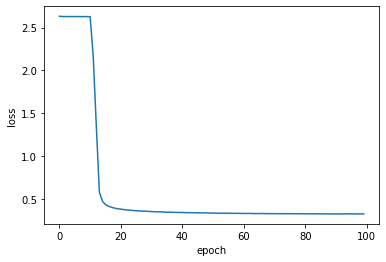

In [13]:
import matplotlib.pyplot as plt

plt.plot(loss)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

In [ ]:
model.net.save_parameters('lenet_sgd_100_epochs.params')

In [27]:
model.net.load_parameters('lenet_sgd_100_epochs.params')
par=dict()
for name,gluon_par in model.net.collect_params().items():
    par.update({name:gluon_par.data()})

In [28]:
total_samples,total_labels=inference.predict(par,batch_size=batch_size,data_loader=val_data)

In [29]:
y_hat=np.quantile(total_samples,.1,axis=0)

In [30]:
from sklearn.metrics import classification_report

print(classification_report(np.int32(total_labels),np.int32(y_hat)))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99       979
           1       0.99      1.00      0.99      1133
           2       0.98      0.99      0.99      1030
           3       0.97      0.99      0.98      1008
           4       0.98      1.00      0.99       980
           5       0.99      0.99      0.99       890
           6       0.99      0.99      0.99       956
           7       0.99      0.99      0.99      1027
           8       0.99      0.98      0.98       973
           9       1.00      0.96      0.98      1008

    accuracy                           0.99      9984
   macro avg       0.99      0.99      0.99      9984
weighted avg       0.99      0.99      0.99      9984



# Stochastic Gradient Langevin Dynamics <a class="anchor" id="chapter2"></a>

In [31]:
from hamiltonian.inference.sgld import sgld
from hamiltonian.models.softmax import softmax

model=lenet(hyper,in_units,out_units,ctx=model_ctx)
inference=sgld(model,model.par,step_size=0.1,ctx=model_ctx)

In [39]:
import importlib
import hamiltonian
importlib.reload(hamiltonian.models.softmax)
importlib.reload(hamiltonian.inference.sgld)

<module 'hamiltonian.inference.sgld' from '../hamiltonian/inference/sgld.py'>

In [40]:
par,loss,posterior_samples=inference.fit(epochs=100,batch_size=batch_size,
                             data_loader=train_data,
                             verbose=True)

  1%|          | 1/100 [00:26<43:10, 26.17s/it]

loss: 3.4063


 11%|█         | 11/100 [04:46<38:41, 26.09s/it]

loss: 3.2458


 21%|██        | 21/100 [09:08<34:28, 26.18s/it]

loss: 3.1929


 31%|███       | 31/100 [13:29<30:00, 26.09s/it]

loss: 3.2860


 41%|████      | 41/100 [18:15<28:58, 29.46s/it]

loss: 3.3041


 51%|█████     | 51/100 [23:21<24:54, 30.51s/it]

loss: 3.2139


 61%|██████    | 61/100 [28:35<20:34, 31.65s/it]

loss: 3.3876


 71%|███████   | 71/100 [33:42<14:50, 30.71s/it]

loss: 3.2885


 81%|████████  | 81/100 [38:57<09:55, 31.32s/it]

loss: 3.3239


 91%|█████████ | 91/100 [44:14<04:41, 31.31s/it]

loss: 3.2555


100%|██████████| 100/100 [48:54<00:00, 29.35s/it]


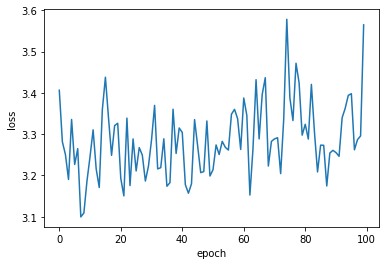

In [41]:
import matplotlib.pyplot as plt

plt.plot(loss)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

In [42]:
len(posterior_samples)

10

In [45]:
posterior_samples.keys()

dict_keys(['0.weight', '0.bias', '2.weight', '2.bias', '4.weight', '4.bias', '5.weight', '5.bias', '6.weight', '6.bias'])

In [46]:
samples=[]
for i in range(len(posterior_samples)):
    par={name:posterior_samples[name][i] for name in posterior_samples.keys()}
    y_pred=model.predict(par,nd.array(X_test,ctx=model_ctx))
    samples.append(y_pred.sample().asnumpy())
samples=np.asarray(samples)

In [ ]:
total_labels=[]
total_samples=[]
for X_test,y_test in val_data:
    X_test=X_test.as_in_context(model_ctx)
    samples=[]
    for i in range(len(posterior_samples)):
        par={name:posterior_samples[name][i] for name in posterior_samples.keys()}
        y_pred=model.predict(par,nd.array(X_test,ctx=model_ctx))
        if X_test.shape[0]==batch_size:
            for _ in range(100):
                samples.append(y_pred.sample().asnumpy())
                total_samples.append(np.asarray(samples))
                total_labels.append(y_test.asnumpy())
total_samples=np.concatenate(total_samples,axis=1)
total_labels=np.concatenate(total_labels)  

In [47]:
from sklearn.metrics import classification_report


y_hat=np.quantile(samples,.5,axis=0)

print(classification_report(np.int32(y_test),np.int32(y_hat)))

ValueError: setting an array element with a sequence.

In [ ]:
samples=[]
for i in range(30):
    par={name:posterior_samples[name][i] for name in posterior_samples.keys()}
    y_pred=model.predict(par,nd.array(X_test,ctx=model_ctx))
    samples.append(y_pred.log_prob(nd.array(y_test,ctx=model_ctx)))
samples=np.asarray(samples)


# Bayes by Backprop <a class="anchor" id="chapter3"></a>

In [ ]:
par={'weights':nd.random_normal(shape=(num_inputs,num_outputs),ctx=model_ctx),
     'bias':nd.random_normal(shape=num_outputs,ctx=model_ctx)}
hyper={'alpha':10.}

In [ ]:
from hamiltonian.inference.bbb import bbb
from hamiltonian.models.softmax import softmax

model=mlp_softmax(hyper,in_units,out_units,4,32,ctx=model_ctx)
inference=bbb(model,model.par,step_size=0.05,ctx=model_ctx)

In [ ]:
import importlib
import hamiltonian
importlib.reload(hamiltonian.models.softmax)
importlib.reload(hamiltonian.inference.bbb)

In [ ]:
par,loss,(means,sigmas)=inference.fit(epochs=10,batch_size=64,
                             X_train=X_train,y_train=y_train,
                             verbose=False)

In [ ]:
import matplotlib.pyplot as plt

plt.plot(loss)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

In [ ]:
from sklearn.metrics import classification_report
import mxnet.gluon.probability as mxp

def softplus(x):
    return nd.log(1. + nd.exp(x))

posterior=dict()
for var in par.keys():
    variational_posterior=mxp.normal.Normal(loc=means[var],
                                            scale=softplus(sigmas[var]))
    posterior.update({var:variational_posterior})
    
samples=[]
for _ in range(100):
    post_par=dict()
    for var in par.keys():
        post_par.update({var:posterior[var].sample().as_nd_ndarray()})
    y_pred=model.predict(post_par,nd.array(X_test,ctx=model_ctx))
    samples.append(y_pred.sample().asnumpy())
samples=np.asarray(samples)
y_hat=np.quantile(samples,.5,axis=0)

print(classification_report(np.int32(y_test),np.int32(y_hat)))

# Posterior Diagnostics <a class="anchor" id="chapter4"></a>

In [ ]:
import arviz as az

In [ ]:
np.expand_dims(np.asarray([posterior_samples['0.bias'][0].asnumpy() for sample in posterior_samples['0.bias']]),0).shape

In [ ]:
posterior_samples_numpy=dict()

for var in posterior_samples.keys():
    posterior_samples_numpy.update(
        {var:np.expand_dims(np.asarray(
            [sample.asnumpy() for sample in posterior_samples[var]]),0)
        })


In [ ]:
posterior_samples_numpy['0-weights'].shape

In [ ]:
dataset = az.convert_to_inference_data(posterior_samples_numpy)

In [ ]:
ess=az.ess(dataset)

In [ ]:
ess

In [ ]:
az.summary(dataset)

In [ ]:
784*10+10